![title](CABIN.jpeg)

# Movie Recommendation System

## Overview:

![](https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/best-movies-1614634680.jpg?crop=1.00xw:1.00xh;0,0&resize=980:*)

##   Problem Statement

The rapid growth of data collection has led to a new era of information. Data is being used to create more efficient systems and this is where Recommendation Systems come into play.  Recommendation Systems are a type of **information filtering systems** as they improve the quality of search results and provides items that are more relevant to the search item or are realted to the search history of the user. 

They are used to predict the **rating** or **preference** that a user would give to an item. Almost every major tech company has applied them in some form or the other: Amazon uses it to suggest products to customers, YouTube uses it to decide which video to play next on autoplay, and Facebook uses it to recommend pages to like and people to follow. 
Moreover,  companies like Netflix and Spotify  depend highly on the effectiveness of their recommendation engines for their business and sucees.

Recommender systems have gained significant usage in a number of industries and when efficiently use they help the firms generate a huge amount of revenue and help them gain a competitive advantage over their competitors. 

***For example, Data from Netflix's site shows that 80% of what people watch comes from their recommendation algorithm ("Netflix Research", 2022). As a result, recommender systems generate over $1 billion per year of Netflix's revenue.***


The main objective of this project was to construct a recommendation system based on content or collaborative filtering algorithm, capable of accurately predicting how a user would rate a movie they had not yet viewed based on their historical preferences. 


##   Data Overview

The dataset consisted of several million 5-star ratings obtained from users of the online MovieLens movie recommendation service. The MovieLens dataset has long been used by industry and academic researchers to improve the performance of explicitly-based recommender systems.

For this challenge, we will be using a special version of the MovieLens dataset which is enriched with additional data and resampled for fair evaluation purposes.

### Instantiate comet experiment

In [3]:
# import comet_ml at the top of your file
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="iCbPjOAd54YXBHeiHBB2EY9YQ",
    project_name="unsupervised-learning",
    workspace="nic-py",
)


COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/nic-py/unsupervised-learning/d976008fce5e48878abd85b8ded08c24
COMET INFO:   Uploads:
COMET INFO:     conda-info          : 1
COMET INFO:     conda-specification : 1
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     os packages         : 1
COMET INFO:     source_code         : 1
COMET INFO: ---------------------------
COMET WARNING: Comet has disabled auto-logging functionality as it has been imp

#### Importing Libraries

In [75]:
# Data processing & File Handling:
import pandas as pd
import numpy as np
import re
import pickle

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Feature Engineering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity 
import scipy as sp

# Modeling
from surprise import Reader, Dataset
from surprise import SVD, SVDpp, NormalPredictor, BaselineOnly, NMF, SlopeOne, CoClustering, KNNWithMeans

# Performance Evaluation
from surprise import accuracy
from sklearn.metrics import mean_squared_error
from surprise.model_selection import GridSearchCV, cross_validate, train_test_split

# Libraries used during sorting procedures.
import operator # For item retrieval during iteration 
import heapq # For sorting Large lists

import warnings
warnings.filterwarnings('ignore')

#show full value of dataframe
pd.set_option("display.max_rows", None, "display.max_columns", None)

#### Load Datasets:

In [102]:
# Load .csv files as Pandas DataFrames:
movies = pd.read_csv('movies.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
tags = pd.read_csv('tags.csv')

### Exploratory Data Analysis:

![title](EDA.jpeg)

We began by dusplaying the first few rows of the dataframes to examine the layouts.

In [3]:
# Displaying the first few rows of the movie dataframe:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# Number of Rows in movies dataframe:
print (f'Number of Rows in movies dataset: {movies.shape[0]}')

Number of Rows in movies dataset: 62423


In [5]:
# Displaying the first few rows of the train dataframe:
train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [6]:
# Number of Rows in train dataframe::
print (f'Number of Rows in train dataset: {train.shape[0]}')

Number of Rows in train dataset: 10000038


Plotting the Average movie rating given by all users: 

Average rating in dataset: 3.5333951730983424


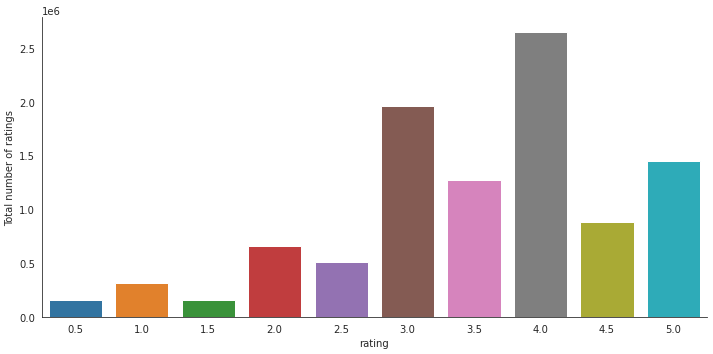

In [7]:
# Visualizing the average movie rating:
with sns.axes_style('white'):
    g = sns.factorplot("rating", data=train, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")
print (f'Average rating in dataset: {np.mean(train["rating"])}')

In [8]:
# Determine and display the min and max ratings received
min_rating = train.rating.min()
max_rating = train.rating.max()
print('Lowest rating: {}'.format(min_rating))
print('Highest rating: {}'.format(max_rating))

Lowest rating: 0.5
Highest rating: 5.0


From the above plot and subsequent function, `Average rating in dataset: 3.53`, `Lowest rating: 0.5` and the `Highest rating: 5.0`.

The `genres` column was considered to contain some useful insights. For the purpose of extracting the same, the column would have to first be cleaned, and a bar plot would be used to visualize the distribution.

In [9]:
# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies.genres = movies.genres.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
movies_df = pd.DataFrame([(tup.movieId, d) for tup in movies.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])

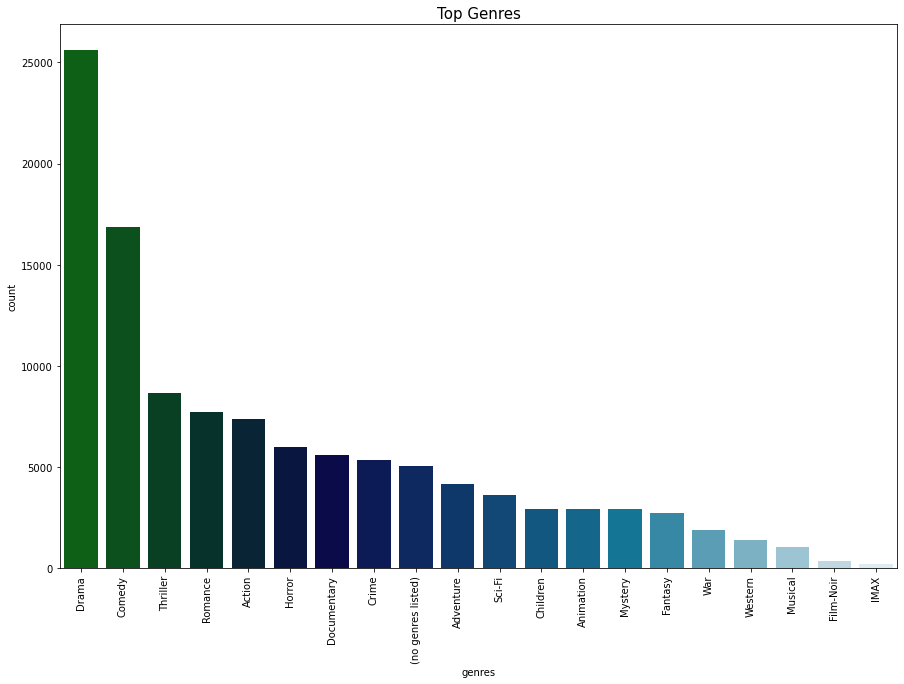

In [10]:
# Plotting top genres in the Dataset
plt.figure(figsize=(15, 10))
gen = movies_df['genres'].explode()
ax=sns.countplot(x=gen, order=gen.value_counts().index[:30],color='b', palette='ocean')
ax.set_title('Top Genres', fontsize=15)
plt.xticks(rotation =90)
plt.show()

With the above barplot, there were some observations to be made. The most commonly occurring genre was `Drama (25,000+ movies)`, followed by `Comedy (17,000+ movies)` and `Thriller (around 9,000 movies)`. 
The least common genres were `IMAX` and `Film-Noir`, which both appeared in `less than 500 movies`.  

The next set of insights would be drawn from examining the number of movies per genre, released annually.

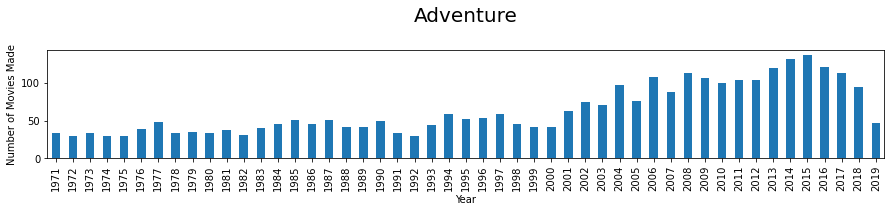

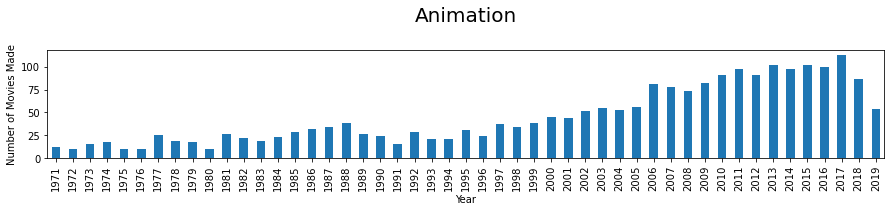

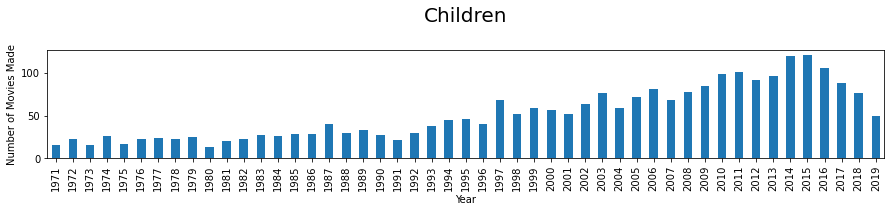

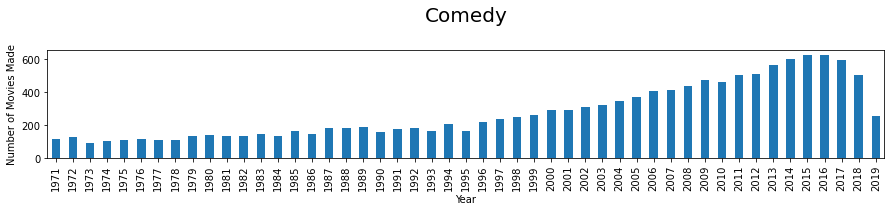

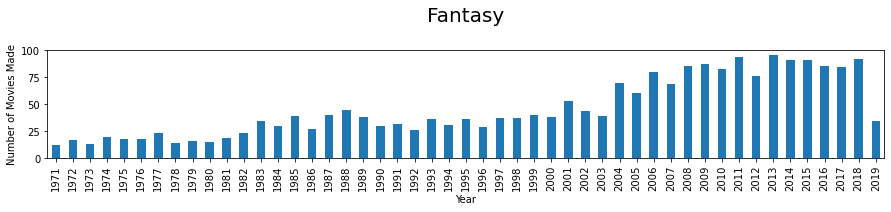

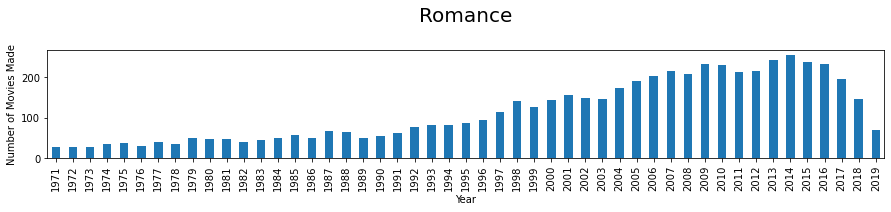

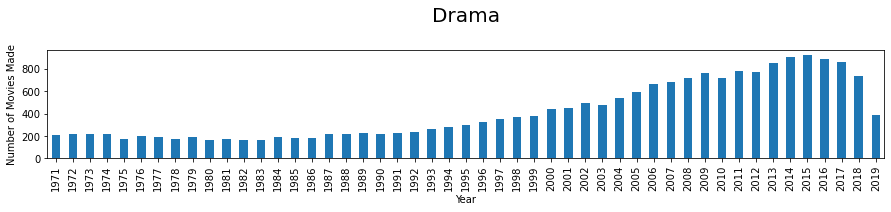

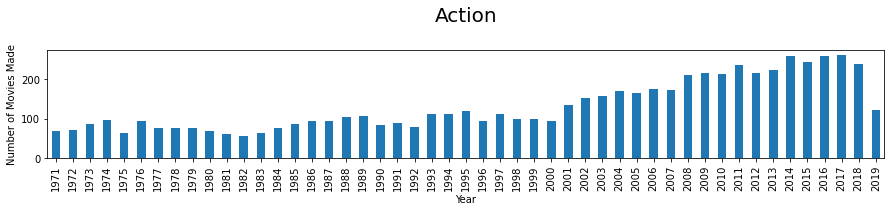

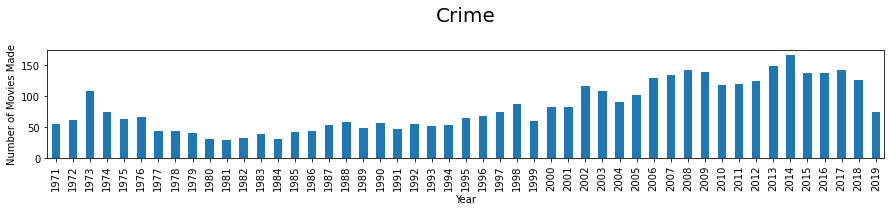

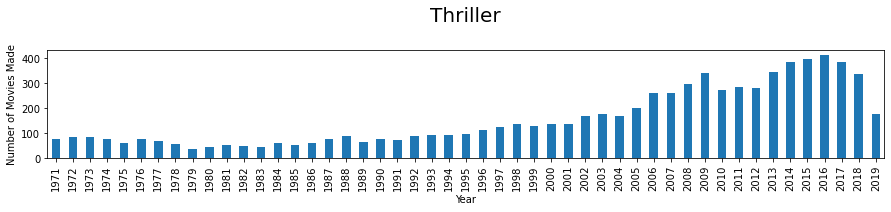

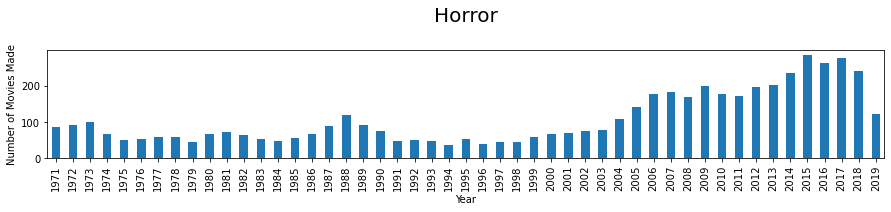

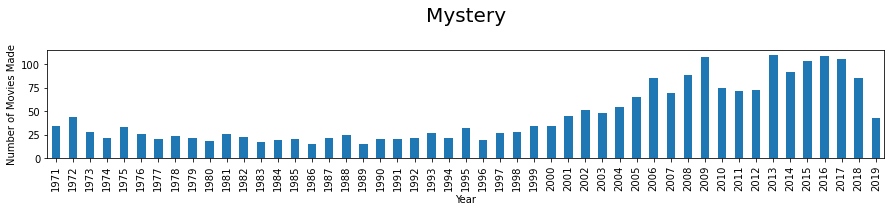

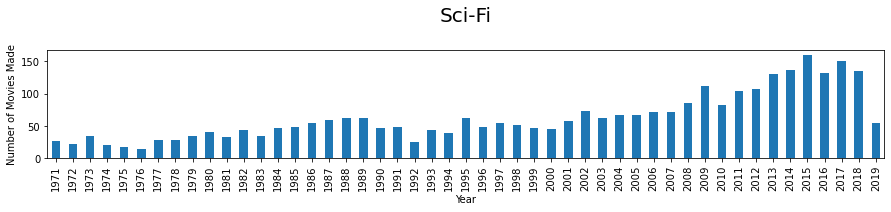

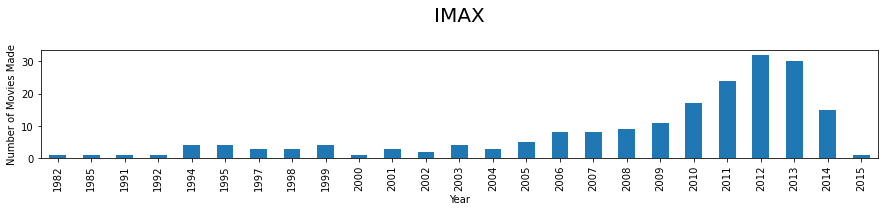

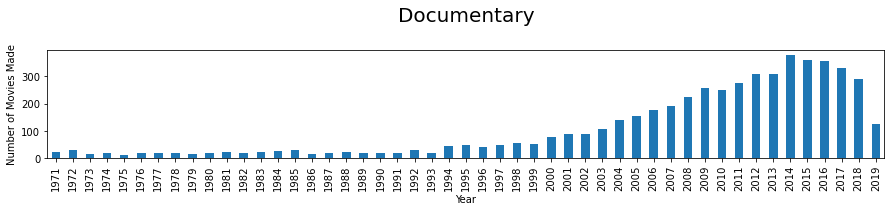

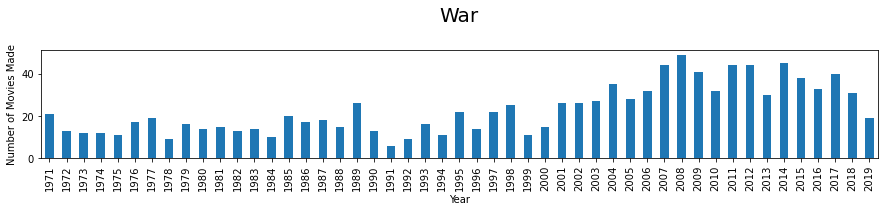

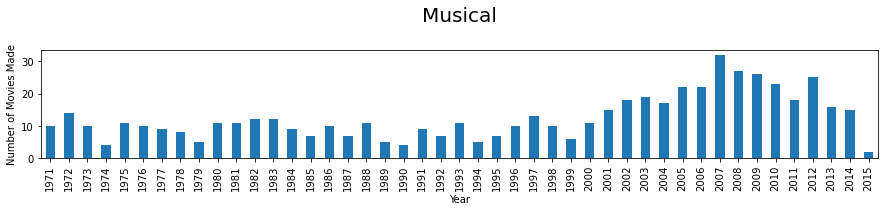

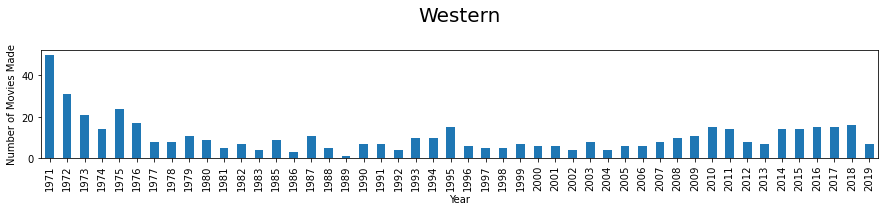

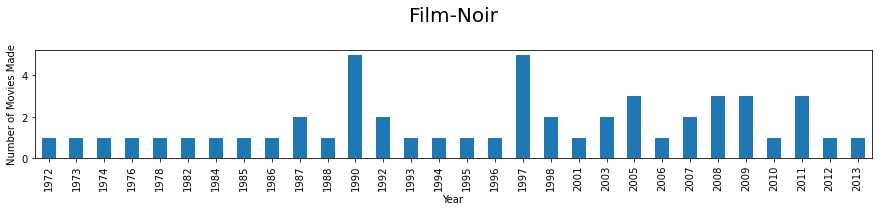

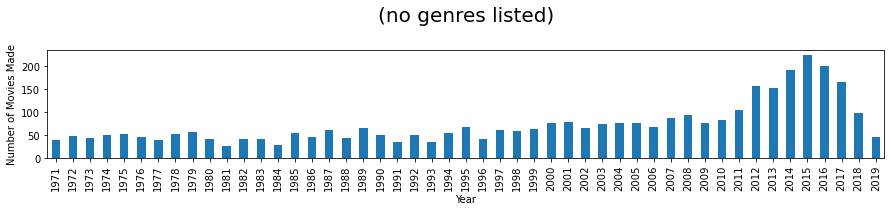

In [11]:
# Add a 'year' column to the movies dataframe that contains the release year of each movie
years = movies.title.apply(lambda x: re.findall(r'\((.[\d]+)\)', x))
movies['year'] = years.str[-1]

# Create a dataframe containing the year and genres for each movie
genres_per_year = pd.merge(movies_df, movies[['movieId', 'year']], on='movieId', how='left')

# Create a list containing all the unique genres present in the dataframe
unique_genres = list(movies_df.genres.unique())

# Plot the number of movies released under each genre from 1970 until 2019
for genre in unique_genres:
    plot = plt.figure(figsize=(15, 2))
    plt.xlabel('Year')
    plt.ylabel('Number of Movies Made')
    plt.title(f'{genre}\n', fontsize=20)
    genres_per_year[genres_per_year.genres == genre][genres_per_year.year.astype(float)
                                                    > 1970].year.value_counts().sort_index().plot(kind='bar',
                                                                                                color='tab:blue')

plt.show()

The obervations made from the above plots were that, for most of the genres there is a `gradual increase from 1970 to 2019`, as more films were being made per year.
The exceptions were `western genre` which has `decreased from 1970 to 2019` and `Film Noir` genre which **doesn't have a stable trend in number of movies over time**.

Next, we looked at a plot that indicated the years with the highest number of released movies:

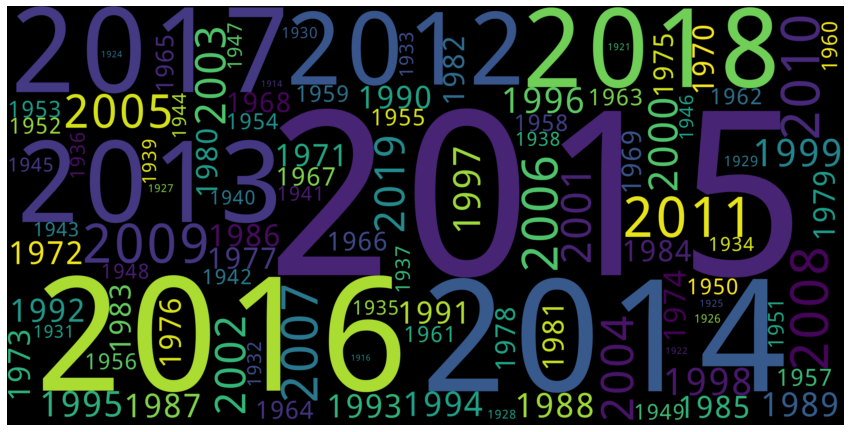

In [12]:
years = movies['year'].value_counts()

#create a word cloud with max 100 
wordcloud = WordCloud(max_words=100, background_color='black', height=2000, width=4000).generate_from_frequencies(years)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### For the wordcloud above, the following observations were made: 
* The years 2015, 2016, 2014, 2017, 2018 have the appear prominently because more movies were released in the 2000s, which is possible due to the invention of streaming technologies.


* We will get more information about this, by plotting a graph that will give us a better visual of the years against the number of released movies.

Next, the number of annual movie releases per year will be visualized. 

Text(0.5, 1.0, 'TOTAL MOVIES RELEASED PER YEAR')

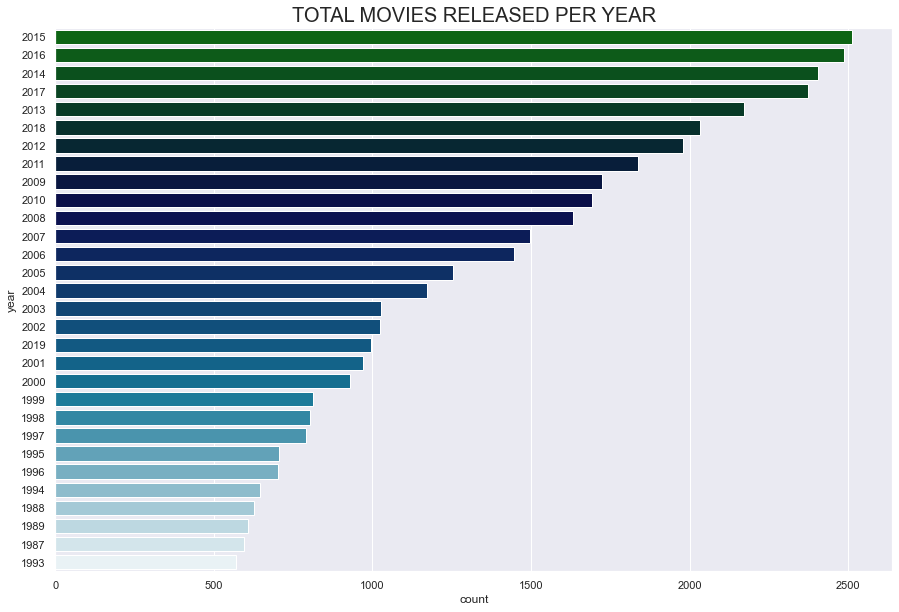

In [13]:
# Plot movies released per year
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
ax = sns.countplot(y=movies['year'], data=movies_df, order=movies['year'].value_counts().index[0:30], palette="ocean")
ax.set_title('TOTAL MOVIES RELEASED PER YEAR', fontsize= 20)


* It was observed that there is a sharp increase in the number of movies released from year 2000.

* 2015 had the highest number of released movies with 2500+ movies, the least number of movies were released in 1993, with less than 700 movies released.

#### **Film Release Summary:**

 1880 - 1930
 
 The first projected movie to a paying audience was in Paris 1895. 
 These were the early stages, at this point movie viewing was basic,
 in __black and white and had no sound__ ,by 1914 several national 
 film industries were established. As more people paid to see movies,
 the industry which grew around them was prepared to invest more money 
 in the production and distribution.
 
 
 
 1930 - 1940
  
 Color was used in films such as __The Wizard of Oz__,from 1935 nearly
 all movies had synchronized sound.The introduction of sound and color 
 gave rise to __‘Golden Age of Hollywood’__ at this stage Cinema was the 
 most popular form of entertainment with people attending cinemas __twice a week__.
  
 
 
 1940 - 1980
 
 We see improvements in cinemas such as __wider screens and better audio.__
 From this point on movie theaters had __better customer experiences__ with
 snacks being served and emphasis on comfort and luxury.

 1980 - 1990
 
 First medium of distribution was invented __VHS__, this widened the range of
 additional customers for movie studios as we see with the __huge spike on the graph__.
 This allowed studios to sell movies directly to customers without the need for them to
 go to Cinemas. This business model was __highly profitable__ and created  new markets 
 such as __rental stores__ which made it more convenient for customers
 
 
 1990 - 2009
 
 __DVD’s became mainstream__, forms of media got cheaper and more accessible to 
 the public, the downfall was caused by the disruption of copying rights.
 A lot of DVD’s were easier to copy  which made it more accessible to people 
 and easy to share.The 2008 financial crisis also played a part in less movies
 being released ( Mitchell, 2021).
 
 2008 +
 
 As the Internet came along which meant easy exchange of media. The industry
 had to adapt to changes that resulted in less movies being released and more
 focus on existing movies, creating rights and properties that can be licensed
 to Streaming platforms such as Netflix,Hulu Amazon etc. (A very short history of cinema 2020)

### Distribution of Movie Ratings:
- The next step was to determine the distribution of ratings given by users for the movies they watched.

In [14]:
num_users = len(train['userId'].unique())
movies_rated = len(train['movieId'].unique())

print("Number of Users: ", num_users)
print("Movies Rated: ", movies_rated)

Number of Users:  162541
Movies Rated:  48213


Next we sampled 50 users to explore the average rating that users give to movies. Most movies were rated between 3 and 4

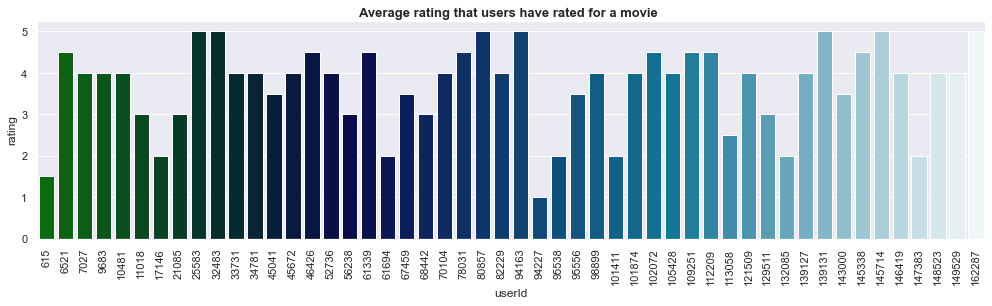

In [15]:
plot = plt.figure(figsize=(17, 4))
plt.figtext(.51, .85, 'Average rating that users have rated for a movie\n',
            fontsize=13, ha='center', fontweight='bold')
sns.barplot(x='userId', y='rating',
            data=train.sample(n=50, random_state=27).sort_values('rating'), palette='ocean')
plt.xticks(rotation='vertical')

plt.show()

In [16]:
users = train.groupby('userId').agg(num_ratings=('movieId', 'size'),
                                       average_rating=('rating', 'mean')).reset_index()

users.describe()

,userId,num_ratings,average_rating
count,162541.00000,162541.000000,162541.000000
mean,81271.00000,61.523173,3.678923
std,46921.68939,107.410889,0.506977
min,1.00000,1.000000,0.500000
25%,40636.00000,14.000000,3.376404
50%,81271.00000,28.000000,3.701493
75%,121906.00000,65.000000,4.000000
max,162541.00000,12952.000000,5.000000


From the above plots, the following observations were made:
* The average rating given across all movies was 3.68/5 with 75% of movies being rated more than 4/5.
* The average rating across all movies was skewed to the right. Most ratings were between 3 & 4. 
* There were very few movies rated at less than 3.4 and that was indicated by the outliers outside of the 1st quantile.
* There were also very few movies rated at 5 and that was indicated by the outliers after the 4th quantile.

We next created a plot to visualize the distribution of average user ratings:

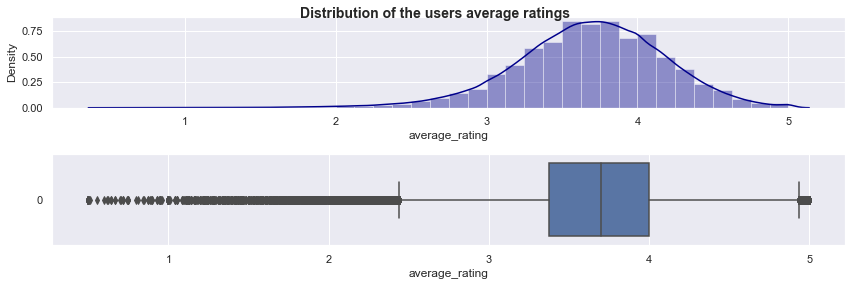

In [17]:
# Plot of distribution of average user ratings:
plot, axes = plt.subplots(2, 1, figsize=(12, 4))
plt.figtext(.51, .95, 'Distribution of the users average ratings', fontsize=14, ha='center',
            fontweight='bold')
sns.distplot(users['average_rating'], hist=True, kde=True,
             bins=int(180/5), color='darkblue', ax=axes[0])

sns.boxplot(data=users['average_rating'],  orient='h', ax=axes[1])
plt.xlabel('average_rating')

plt.tight_layout()
plt.show()


We next created a plot to explore the possible relationship between the total number of ratings given by a user and their average.

The outlier made it difficult to see all the points but we were still able to deduce that there was a pattern between number of ratings and average rating. The more people rated movies, the more their ratings converged to the median rating of 3.

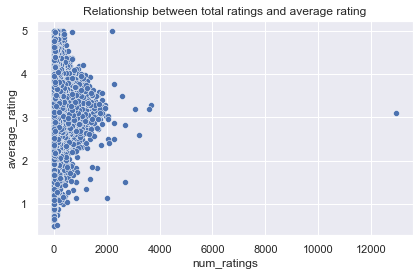

In [18]:
# Scatter plot of total rating vs average rating
plt.title('Relationship between total ratings and average rating', fontsize=12)
sns.scatterplot(x=users['num_ratings'], y=users['average_rating'], data=users)
plt.tight_layout()
plt.show()

### Movie popularity:
We needed to determine the popularity of rated movies among users, therefore we used the product of average rating and the total number of ratings that a film recieved.

In [19]:
rating_df = train.merge(movies, on="movieId", how="inner").dropna(inplace=False)
rating_df.head(2)

,userId,movieId,rating,timestamp,title,genres,year
0,5163,57669,4.0,1518349992,In Bruges (2008),"[Comedy, Crime, Drama, Thriller]",2008
1,87388,57669,3.5,1237455297,In Bruges (2008),"[Comedy, Crime, Drama, Thriller]",2008


In [20]:
# Extract and display the 10 most popular films in the dataset 
# Determine the average rating and number of ratings for each movie
ratings_mean_count = pd.DataFrame(rating_df.groupby(['title'])[['rating']].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(rating_df.groupby(['title'])['rating'].count())
ratings_mean_count['popularity'] = pd.DataFrame(rating_df.groupby(['title'])['rating'].count()*rating_df.groupby(['title'])['rating'].mean())

ratings_mean_count = ratings_mean_count.sort_values(by='popularity', ascending=False).head(10)
ratings_mean_count.head(10)

,rating,rating_counts,popularity
title,,,
"Shawshank Redemption, The (1994)",4.417624,32831,145035.0
Pulp Fiction (1994),4.195097,31697,132972.0
Forrest Gump (1994),4.047216,32383,131061.0
"Silence of the Lambs, The (1991)",4.144172,29444,122021.0
"Matrix, The (1999)",4.154253,29014,120531.5
Star Wars: Episode IV - A New Hope (1977),4.111811,27560,113321.5
Schindler's List (1993),4.247625,24004,101960.0
Fight Club (1999),4.227906,23536,99508.0
Star Wars: Episode V - The Empire Strikes Back (1980),4.146236,22956,95181.0


* An interesting thing we noted was that the top 10 most popular movies are older, with none of the movies being released after the year 1999.
* This just could have been because these movies had been around longer and may have received many ratings as a result.

We created wordclouds depicting the highest rated and lowest rated movies respectively:

#### Highest Ratings:

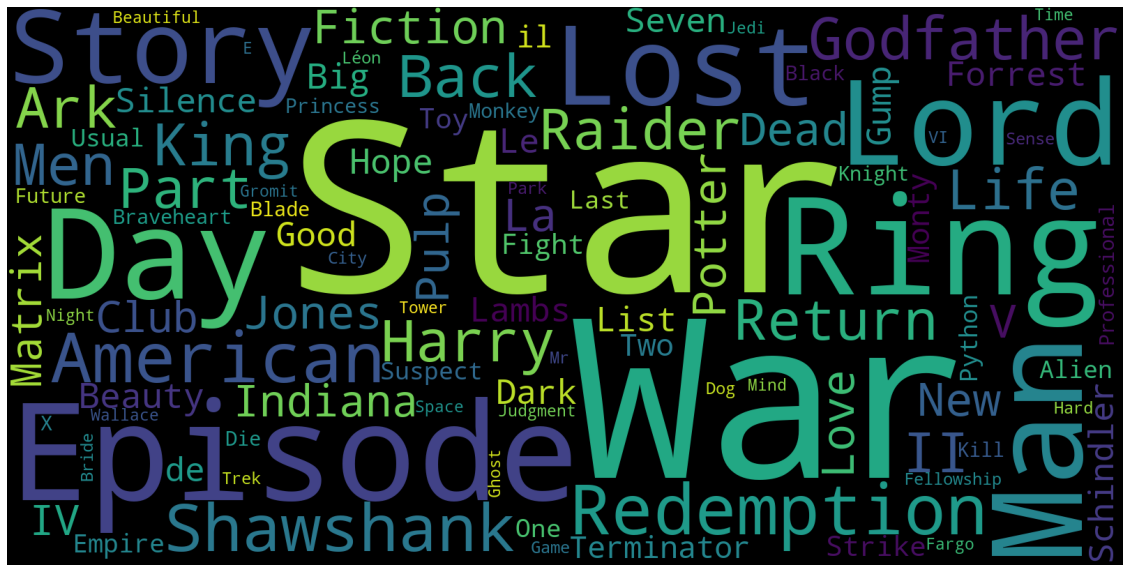

In [21]:
rating_df.rating = rating_df.rating.apply(lambda x: int(x))
High_rating_df = rating_df[rating_df['rating']==5]

Low_rating_df = rating_df[rating_df['rating']==0]

High_rating_list = str(list(High_rating_df['title']))
Low_rating_list = str(list(Low_rating_df['title']))


high_r = rating_df
plt.figure(figsize = (20,20))
wc = WordCloud(background_color = "black", max_words = 100 , 
               width = 1600 , height = 800,collocations=False).generate(High_rating_list)
plt.axis("off")
plt.imshow(wc)

#### Lowest Ratings:

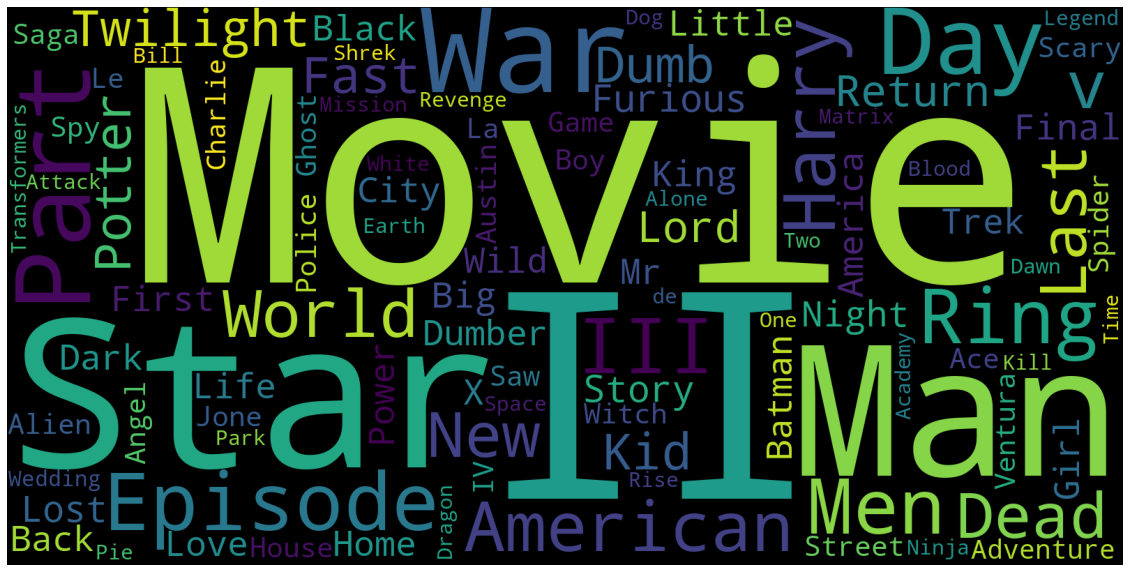

In [22]:
plt.figure(figsize = (20,20))
wc = WordCloud(background_color = "black", max_words = 100 , 
               width = 1600 , height = 800,collocations=False).generate(Low_rating_list)
plt.axis("off")
plt.imshow(wc)

Some movies such as the star, wars, man, appeared in the two word plot. This means it was possible for a movie to recieve the highest and the lowest rating from different users.

Our final plot was a wordcloud displaying the frequency in which movie tags appeared:
The `tags` column was deemed to contain useful data that would later be used in the modelling phase of the project.

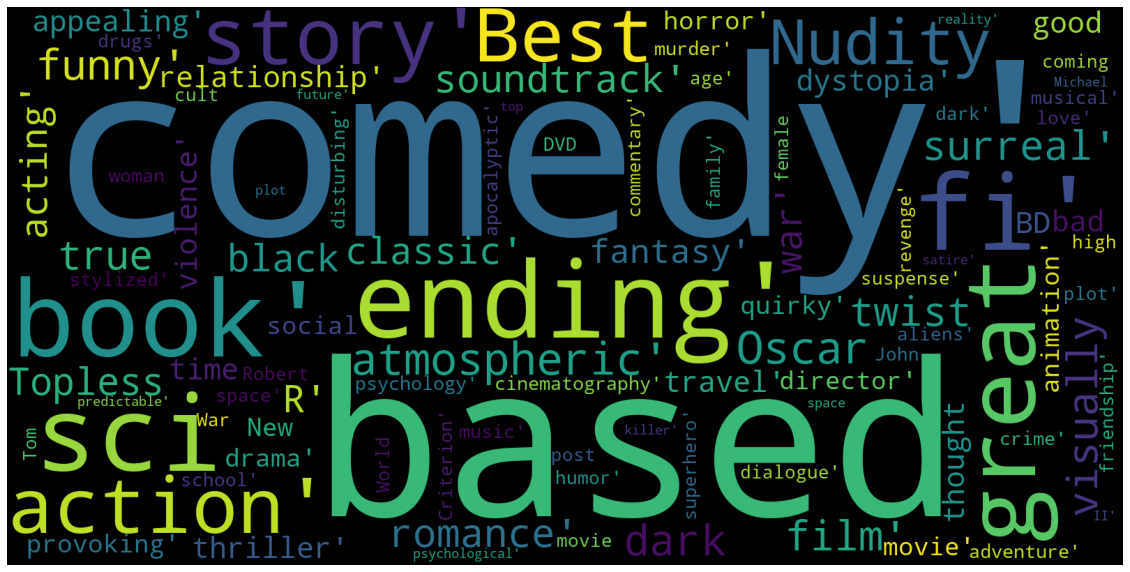

In [23]:
tags_2 =str(list(tags['tag']))
plt.figure(figsize = (20,20))
wc = WordCloud(background_color = "black", max_words = 100 , width = 1600 , height = 800,
               collocations=False).generate(tags_2)
plt.axis("off")
plt.imshow(wc)

In [24]:
# Create list containing the counts
# for each tag in the tags dataframe and sort in descending order of counts
tag_counts = tags['tag'].value_counts(ascending=False)
# Create dataframe showing the top 10 most common tags and their counts
most_common_tags = list(zip(tag_counts[:10].index, tag_counts[:10]))
most_common_tags = pd.DataFrame(most_common_tags)
most_common_tags.columns = ['tag', 'count']
most_common_tags.style.background_gradient(cmap='Purples')

,tag,count
0,sci-fi,8330
1,atmospheric,6516
2,action,5907
3,comedy,5702
4,surreal,5326
5,based on a book,5079
6,twist ending,4820
7,funny,4738
8,visually appealing,4526
9,dystopia,4257


It was observed that the top 3, most frequently occurring tags were `sci-fi`, `atmospheric` and `action`. This is a reflection of the most frequently occurring movie themes in the dataset.

### Data Preprocessing:

![title](preprocessing.jpg)

The purpose of data preprocessing/preparation is to convert the data into the best possible format for Machine Learning. There are 3 stages, Data Cleansing, Data Transformation, and finally Feature Engineering.

#### Viewing the Total Number of Movies:

In [25]:
print('There are a total of: {} movies.'.format(len(movies.movieId.unique())))

There are a total of: 62423 movies.


#### Viewing the Total Number of Rated Movies:

In [26]:
print('There are a total of: {} rated movies.'.format(len(train.movieId.unique())))

There are a total of: 48213 rated movies.


It can be observed that `There are a total of: 62423 movies.` and `There are a total of: 48213 rated movies.`

### Reducing the Size of the Data:

After considering the size of the dataset and it's impact on computational efficiency, we decided to reduce the overall size of the data by filtering it, only retaining the data containing users who rated **at least 500** movies.

In [27]:
# Reduce data by retaining users that have rated at least x movies:
u_ratings = train.groupby('userId').filter(lambda x: len(x) >= 500)

We stored the remaining movies in a list:

In [28]:
# List the remaining movies after filtering:
new_movie_list = u_ratings.movieId.unique().tolist()

We **see** the retained data by the **percentage** of movies and users **retained**:

In [29]:
# Look at how much of the movies data has been retained:
print('We have retained, {}% of movies.'.format(round(len(u_ratings.movieId.unique()) / len(movies.movieId.unique()) * 100)))

We have retained, 68% of movies.


In [30]:
# look at number of users retained after filtering:
print('We have retained, {}% of users.'.format(round(len(u_ratings.movieId.unique()) / len(train.movieId.unique()) * 100)))

We have retained, 88% of users.


`68% of movies` and `88% of users` were retained. This was found to be an acceptable size for a subset of the original data. 

The new data subset will then be used to replace the original dataset.  

In [31]:
# New size of the movies dataframe:
movies = movies[movies.movieId.isin(new_movie_list)]

In [32]:
# Display smaller subset of the movies dataset:
movies.head()

,movieId,title,genres,year
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II (1995),[Comedy],1995


Before going any further, we should drop some columns in our data that are irrelevant. These are, `timestamp`.

In [33]:
# Drop timestamp column as it is irrelevant:
tags.drop(['timestamp'], axis=1, inplace=True)
u_ratings.drop(['timestamp'], axis=1, inplace=True)

For the purpose of supplementing the data quality, there is a need to merge the datasets and combine tags and genres columns.

In [34]:
merged_df = pd.merge(movies, tags, on='movieId', how='left')

In [35]:
merged_df.head()

,movieId,title,genres,year,userId,tag
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995,791.0,Owned
1,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1048.0,imdb top 250
2,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1361.0,Pixar
3,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995,3164.0,Pixar
4,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995,3164.0,time travel


In [36]:
#### Convert the rows in `genres` column from lists to strings:
merged_df['genres'] = merged_df['genres'].apply(lambda x: ' '.join(x))

In [37]:
merged_df.head()

,movieId,title,genres,year,userId,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1995,791.0,Owned
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1995,1048.0,imdb top 250
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1995,1361.0,Pixar
3,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1995,3164.0,Pixar
4,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1995,3164.0,time travel


Because multiple rows appear for each movie id, because of the tags column, there is a need to combine the tags with the genres to create a new column containing the combined **`metadata`** for each movie.

In [38]:
# Creating new feature: metadata
# Fill Nulls with an empty string:
merged_df.fillna('', inplace=True)

merged_df = pd.DataFrame(merged_df.groupby('movieId')['tag'].apply(lambda x: '%s' % ' '.join(x)))


In [39]:
# Merge the movies dataset with the original merged_df:
new_meta = pd.merge(movies, merged_df, on='movieId', how='left')


In [40]:
new_meta.head()

,movieId,title,genres,year,tag
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995,Owned imdb top 250 Pixar Pixar time travel chi...
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",1995,Robin Williams time travel fantasy based on ch...
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995,funny best friend duringcreditsstinger fishing...
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1995,based on novel or book chick flick divorce int...
4,5,Father of the Bride Part II (1995),[Comedy],1995,aging baby confidence contraception daughter g...


In [41]:
#### Convert the rows in `genres` column from lists to strings:
new_meta['genres'] = new_meta['genres'].astype('str')

At this point there was a need to create a new column, `metadata` in the current dataframe, by combining the contents of both `tag` and `genres` columns.

In [42]:
new_meta['metadata'] = new_meta[['tag', 'genres']].apply(lambda x: ' '.join(x), axis=1)

There was a need to retain only the relevant columns, `	movieId, title, metadata`.

In [43]:
new_meta = new_meta[['movieId', 'title', 'metadata']]

new_meta.head()

,movieId,title,metadata
0,1,Toy Story (1995),Owned imdb top 250 Pixar Pixar time travel chi...
1,2,Jumanji (1995),Robin Williams time travel fantasy based on ch...
2,3,Grumpier Old Men (1995),funny best friend duringcreditsstinger fishing...
3,4,Waiting to Exhale (1995),based on novel or book chick flick divorce int...
4,5,Father of the Bride Part II (1995),aging baby confidence contraception daughter g...


With the new filtered dataset, that will be used in the subsequent step of model building.

In [44]:
print('Total Rows: {}'.format(new_meta.shape[0])) # Number of rows
print('Total Columns: {}'.format(new_meta.shape[1])) # Number of columns

Total Rows: 42406
Total Columns: 3


### Feature Engineering:

![title](feature_engineering.png)

Feature engineering is a machine learning technique that makes use of the available data to create new variables that are not already present in a dataset. This process can result in he creation of new features for both supervised and unsupervised learning, with the goal of simplifying and speeding up data transformations while also enhancing model accuracy. Feature engineering is required when working with machine learning models. Regardless of the data or architecture, a terrible feature will have a direct impact on your model.

When done correctly, the resulting dataset is optimal and contains all of the important factors that affect a specific problem. With this, the most accurate predictive models and the most useful insights are produced.

We started by separating movie **titles** and their **indices**.

In [45]:
# Movie titles:
titles = new_meta['title']

# Movie indices:
indices = pd.Series(new_meta.index, index=new_meta['title'])

The next step was to extract features from the metadata. For this, a vectorizer was used.

In [46]:
# Create an Instance of the vectorizer class: TfidfVectorizer()
vectorizer = TfidfVectorizer(stop_words='english') # also remove stop words
features = vectorizer.fit_transform(new_meta['metadata']) 

#cv = CountVectorizer()
# Use the vectorizer to extract features:
#count_matrix = cv.fit_transform(new_meta['metadata']) 

Afterwards, the cosine similarity metrix was used to measure the similarity within our features.

In [47]:
# create variable to contain the cosine similarity matrix:
cosine_sim_features = cosine_similarity(features, features)
print (cosine_sim_features.shape)

(42406, 42406)


In [49]:
cosine_sim_features[:5] # Displaying the first five indices

array([[1.00000000e+00, 5.17789452e-02, 1.63736213e-02, ...,
        0.00000000e+00, 0.00000000e+00, 1.78183761e-02],
       [5.17789452e-02, 1.00000000e+00, 6.05660485e-04, ...,
        0.00000000e+00, 0.00000000e+00, 1.40639730e-01],
       [1.63736213e-02, 6.05660485e-04, 1.00000000e+00, ...,
        0.00000000e+00, 3.39381929e-02, 0.00000000e+00],
       [3.24153720e-03, 7.59378860e-02, 1.34052807e-02, ...,
        0.00000000e+00, 1.03679236e-01, 0.00000000e+00],
       [2.28311153e-02, 2.66362177e-02, 7.76788314e-02, ...,
        0.00000000e+00, 0.00000000e+00, 6.57114449e-02]])

The resulting structure is a $42406 \times 42406$ dense similarity matrix $S^I$, where the value of the entry in the $i^{th}$ row and $j^{th}$ column, $S^I_{i,j}$, corresponds to the similarity of movies $i$ and $j$ within our dataset.

Using this notation, if $i$ and $j$ are the same number (i.e. all the diagonal entries in $S^I$), then the similarity value is equal to 1 (an item is completely similar to itself).  

## Model Creation:

![](model.jpg)

### i) Content-Based Filtering: 

Having the content similarity matrix computed, it was ready to make some recommendations! We began by generating a list of movies similar to ones we prompt the system with.    

The following would be done: 

  1. Select the initial movie(s) from which recommendations will be generated. 
  2. Extract all the similarity values between the initial movie and every other one in the similarity matrix.
  3. Sort the resulting values in descending order. 
  4. Select the top N similarity values, and return the corresponding item details to the user. This is now our simple top-N list.  
  

We are finally at the point where we will build a function to carry out recommendation using content based filtering.

In [50]:
def content_generate_top_N_recommendations(movie_title, N=10):
    
    # Convert the string movie title to a numeric index for our 
    # similarity matrix
    m_idx=[]
    for i in movie_title:
        m_idx.append(indices[i])
    
    # Extract all similarity values computed with the reference movie title
    sim_scores1 = list(enumerate(cosine_sim_features[m_idx[0]]))
    sim_scores2 = list(enumerate(cosine_sim_features[m_idx[1]]))
    sim_scores3 = list(enumerate(cosine_sim_features[m_idx[2]]))

    sim_scores = sim_scores1 + sim_scores2 + sim_scores3

    # Sort the values, keeping a copy of the original index of each value
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Select the top-N values for recommendation
    sim_scores = sim_scores[1:N*2]
    
    # Collect indexes 
    movie_indices = [i[0] for i in sim_scores]

    movie_indices = np.setdiff1d(movie_indices, m_idx)
          
    # Convert the indexes back into titles 
    return titles.iloc[movie_indices[:10]]

#### Making Movie Recommendations:

In [51]:
# Top 10 based on three movies chosen
content_generate_top_N_recommendations(['Toy Story (1995)', 'Othello (1995)', 'GoldenEye (1995)'], N=10)

1640                           Tomorrow Never Dies (1997)
2240                                 Bug's Life, A (1998)
2506    William Shakespeare's A Midsummer Night's Drea...
2828                                    Goldfinger (1964)
2829                         From Russia with Love (1963)
2830                                        Dr. No (1962)
2868                            For Your Eyes Only (1981)
2870                              Live and Let Die (1973)
2872                                   Thunderball (1965)
2960                      World Is Not Enough, The (1999)
Name: title, dtype: object

With the function created, we can test it by recommending the top-10 movies similar to `Toy Story (1995), 'Othello (1995)', 'GoldenEye (1995)`.

From the above list of movie recommendations, we can observe that the each of the films have similar themes suited for the same audience demography.

With this new list of movie recommendations, we can observe that all are comedy films, each with similar themes suited for the same audience demography.

#### Predicting User Ratings:

For the next task under collaborative filtering, we will attempt to predict the ratings that users will give to films that they have not yet seen, based on past ratings on films they have seen.

We will begin by creating a new dataset by merging movie data with their respective user-ratings.

In [52]:
# Merge user-ratings with movie-data:
ratings = pd.merge(movies[['movieId']], u_ratings, on='movieId', how='right')

In [53]:
ratings = pd.merge(new_meta[['movieId', 'title']], ratings, on='movieId', how='right')

In [54]:
ratings.head()

,movieId,title,userId,rating
0,32296,Miss Congeniality 2: Armed and Fabulous (2005),106362,2.0
1,41571,Memoirs of a Geisha (2005),95075,3.0
2,6538,Swimming Pool (2003),89538,3.5
3,89745,"Avengers, The (2012)",50882,5.0
4,6998,House of Cards (1993),97452,3.5


As before, the next step will be to create a function that will predict user ratings for unseen movies:

In [55]:
def content_rating_estimate(m_title, user, rating_data, k=20, threshold=0.0):
    # Convert the book title to a numeric index for our 
    # similarity matrix
    m_ind = indices[title]
    neighbors = [] # <-- Stores our collection of similarity values 
     
    # Gather the similarity ratings between each book the user has rated
    # and the reference book 
    for index, row in rating_data[rating_data['userId']==user].iterrows():
        sim = cosine_sim_features[m_ind-1, indices[row['title']]-1]
        neighbors.append((sim, row['rating']))
    # Select the top-N values from our collection
    k_neighbors = heapq.nlargest(k, neighbors, key=lambda t: t[0])

    # Compute the weighted average using similarity scores and 
    # user item ratings. 
    simTotal, weightedSum = 0, 0
    for (simScore, rating_data) in k_neighbors:
        # Ensure that similarity ratings are above a given threshold
        if (simScore > threshold):
            simTotal += simScore
            weightedSum += simScore * rating_data
    try:
        predictedRating = weightedSum / simTotal
    except ZeroDivisionError:
        # Cold-start problem - No ratings given by user. 
        # We use the average rating for the reference item as a proxy in this case 
        predictedRating = np.mean(rating_data[rating_data['title']==title]['rating'])
    return predictedRating

We looked at some of the ratings that a single user: `userId: 50882`, gave to movies that they have seen:

In [62]:
# Subset of ratings from a single user 
ratings[ratings['userId'] == 50882][3:10]

,movieId,title,userId,rating
5573,1333,"Birds, The (1963)",50882,3.0
6993,919,"Wizard of Oz, The (1939)",50882,2.5
11075,87522,Larry Crowne (2011),50882,4.5
12626,122912,Avengers: Infinity War - Part I (2018),50882,5.0
14145,1240,"Terminator, The (1984)",50882,3.5
15090,34150,Fantastic Four (2005),50882,3.5
16023,122892,Avengers: Age of Ultron (2015),50882,4.5


With this we can attempt, using our function to predict their ratings for some of the movies that they have already watched:

In [70]:
title = 'Fantastic Four (2005)'
actual_rating = ratings[(ratings['userId'] == 50882) & (ratings['title'] == title)]['rating'].values[0]
pred_rating = content_rating_estimate(m_title=title, user=50882, rating_data=ratings)
print (f"Title - {title}")
print ("****")
print (f"Actual rating: \t\t {actual_rating}")
print (f"Predicted rating: \t {pred_rating}")

Title - Fantastic Four (2005)
****
Actual rating: 		 3.5
Predicted rating: 	 3.5035441835990793


In [67]:
title = 'Avengers: Age of Ultron (2015)'
actual_rating = ratings[(ratings['userId'] == 50882) & (ratings['title'] == title)]['rating'].values[0]
pred_rating = content_rating_estimate(m_title=title, user=50882, rating_data=ratings)
print (f"Title - {title}")
print ("****")
print (f"Actual rating: \t\t {actual_rating}")
print (f"Predicted rating: \t {pred_rating}")

Title - Avengers: Age of Ultron (2015)
****
Actual rating: 		 4.5
Predicted rating: 	 4.0273837978242435


Now let's attempt to get predictions for some movies that they have neither seen nor rated:

In [71]:
title = 'Toy Story 2 (1999)'
pred_rating = content_rating_estimate(m_title=title, user=50882, rating_data=ratings)
print (f"Title - {title}")
print ("****")
print (f"Actual rating: \t\t ...")
print (f"Predicted rating: \t {pred_rating}")

Title - Toy Story 2 (1999)
****
Actual rating: 		 ...
Predicted rating: 	 3.1265731949817446


In [72]:
title = 'Father of the Bride Part II (1995)'
pred_rating = content_rating_estimate(m_title=title, user=50882, rating_data=ratings)
print (f"Title - {title}")
print ("****")
print (f"Actual rating: \t\t ...")
print (f"Predicted rating: \t {pred_rating}")

Title - Father of the Bride Part II (1995)
****
Actual rating: 		 ...
Predicted rating: 	 3.7463134156957913


Based on the above results, the content-based ratings appeared promising - being out by than less 1 rating point for known predictions! While the same observation was not made for the predicted ratings of unseen movies, they apeared to be close to known book ratings which are similar in nature, which was reassuring.

<a id="subsection-2"></a>
### ii) Collaborative Filtering:

Collaborative methods for recommender systems are methods that are based solely on the past interactions recorded between users and items in order to produce new recommendations. These methods do not require item metadata like their content-based counterparts. This makes them less memory intensive which is especially advantageous when dealing with large datasets such as this one.


### There are 2 Collaborative Filtering Methods:

#### Memory based.

We will investigate 2 two memory based methods: User-user and item-item. The main characteristics of user-user and item-item approaches is that they use only information from the user-item interaction matrix and they assume no model to produce new recommendations.

#### Model based.

Model based collaborative approaches only rely on user-item interactions information and assume a latent model supposed to explain these interactions. For example, matrix factorisation algorithms consists in decomposing the huge and sparse user-item interaction matrix into a product of two smaller and dense matrices: a user-factor matrix (containing users representations) that multiplies a factor-item matrix (containing items representations).

### a) User-User Collaborative Filtering:

This kind examines the shared patterns of interest of similar users, it then uses the choices and preference of similar users to suggest new items.


In order to make a new recommendation to a user, the user-user method roughly tries to identify users with the most similar “interactions profile” (nearest neighbours) in order to suggest movies that are the most popular among these neighbours (and that are “new” to our user). This method is said to be “user-centred” as it represents users based on their interactions with items and evaluates distances between users.


In [76]:
# Creating a small test dataframe to evaluate our models
tests = train.copy()
tests.drop(['timestamp'], axis=1, inplace=True)
tests = tests.head(10000)

# Creating the training data
reader = Reader(rating_scale=(0.5, 5))
test_data = Dataset.load_from_df(tests[['userId','movieId','rating']], reader)

# Compute similarities between users using cosine distance
sim_options = {"name": "cosine",
               "user_based": True}  

# Evaluate the model 
user = KNNWithMeans(sim_options=sim_options)
cv = cross_validate(user, test_data, cv=5, measures=['RMSE'], verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1161  1.0876  1.0983  1.1150  1.1138  1.1062  0.0113  
Fit time          1.00    0.98    0.97    0.98    1.00    0.99    0.01    
Test time         0.02    0.00    0.01    0.03    0.02    0.01    0.01    


**Observations and Limitations:**
* The user-based collaborative technique produced a RMSE score of 1.11 (based on a 1% sample of the train data).

* Even though user-based collaborative techniques are powerful, there are few challenges; scalability and sparsity are the primary issues.

* **Scalability:** In a system with many new users, (users with low records of ratings), it is computationally expensive and inefficient to train the model. These problems are encountered with Nearest Neighbour algorithms in user-based collaborative filtering, where these algorithms require computations that grow simultaneously with the increasing numbers of users and items. (Cold start), in a no-model based system, this problem is overcome by recommending the movies with the highest number of ratings.

* **Data Sparsity:** Sparsity arises in a system when even the most active users have rated only a marginal number of available items. For example, these users may have experience with even less than 1% of available items making the correlation coefficient less reliable.

* Another concern is that **user profiles change** quickly and the entire system model will have to be recompute, which is both time and computationally expensive.

* If a recommender system experiences any of these described issues, the algorithm's performance decreases; i.e. the system does not recommend the user relevant items.

### b) Item-Item collaborative Filtering:

Considering the problens encountered with the user-based collaborative filtering technique, the item-based collaborative technique will be utilized. It analyzes the user-item matrix and identifies the relationships between different items. The item-based recommendation system then makes recommendations based on the similarities discovered among the items. This method is more stable compared to user-based collaborative filtering because the average item has a many more ratings than the average user gives. So an individual rating does not have a big impact.

The idea of the item-item method is to find movies similar to those that the user has already interacted “positively” with. Two items are considered to be similar if most of the users, having interacted with both of them, did so in a similar way. This method is said to be “item-centred” as it represents items based on interactions users had with them and evaluates the distances between them items.

In [77]:
# Compute similarities between movies using cosine distance
sim_options = {"name": "cosine",
               "user_based": False}  

# Fit the KNNwithmeans algorithm to the training set
item_based = KNNWithMeans(sim_options=sim_options)

# Evaluate the model 
cv = cross_validate(item_based, test_data, cv=5, measures=['RMSE'], verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0881  1.0836  1.0724  1.0931  1.0824  1.0839  0.0069  
Fit time          0.22    0.21    0.19    0.18    0.21    0.20    0.01    
Test time         0.01    0.01    0.02    0.02    0.01    0.01    0.00    


**Observations and Limitations:**

* Using Item Based Collaborative Filtering gave the RMSE score of 1.08 (based on a 1% sample of the train data) which is only a slight improvement on the User Based Collaborative Filtering method.

### c) Model Based Collaborative Filtering:

We will next train and evaluate the performance of the models based on a subset of the data containing 100,000 samples. The best performing model will then undergo hyperparameter tuning and be trained on the already established subset of the full dataset, for the submission file.

In this section, seven models from the surprise package will be explored.

In [78]:
ratings.head()

,movieId,title,userId,rating
0,32296,Miss Congeniality 2: Armed and Fabulous (2005),106362,2.0
1,41571,Memoirs of a Geisha (2005),95075,3.0
2,6538,Swimming Pool (2003),89538,3.5
3,89745,"Avengers, The (2012)",50882,5.0
4,6998,House of Cards (1993),97452,3.5


In [79]:
print (f'Number of ratings in dataset: {ratings.shape[0]}')

Number of ratings in dataset: 1180913


In [82]:
# Load the filtered dataset:
#ratings_subset = ratings[:100000]
reader = Reader(rating_scale=(ratings['rating'].min(), ratings['rating'].max()))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25, random_state=42)

#### __Singular Value Decomposition (SVD)__

Unlike Memory-Based Approaches, Model-Based procedures facilitate machine learning techniques such as Singular Value Decomposition (SVD) and Matrix Factorization models to predict the end user's rating on unrated items. 

We will be using SVD to build our recommender engine. We utilize the results of singular value decomposition (SVD) to fill the vacant ratings and then use the item based method to produce the prediction of unrated items.

Formally, SVD is decomposition of a matrix R which is the utility matrix with m equal to the number of users and m number exposed items (movies) into the product of three matrices:

* U is a left singular orthogonal matrix, representing the relationship between users and latent factors (Hopcroft & Kannan, 2012)

* Σ is a diagonal matrix (with positive real values) describing the strength of each latent factor

* V(transpose) is a right singular orthogonal matrix, indicating the similarity between items and latent factors.

![2020/02/svd2.png](https://www.dataminingapps.com/wp-content/uploads/2020/02/svd2.png)

The general goal of SVD (and other matrix factorization methods) is to decompose the matrix R with all missing values and multiply its components, U, Σ and V once again. As a result, there are no missing values and it is possible to recommend each user movies (items) they have not seen yet.

In [88]:
# Create instance of SVD model:
svd_sub = SVD()

# Training the SVD Model:
svd_sub.fit(trainset)

# Making predictions:
svd_pred = svd_sub.test(testset)

# Model Preformance:
svd_rmse = accuracy.rmse(svd_pred)

RMSE: 0.7965


#### NormalPredictor Algorithm:

The `NormalPredictor` algorithm will predict a random rating based on the distribution of the training set that is assumed to be normal.

In [89]:
# Create instance of NormalPredictor model:
np_sub = NormalPredictor()

# Training the Model:
np_sub.fit(trainset)

# Making predictions:
np_pred = np_sub.test(testset)

# Model Performance:
np_rmse = accuracy.rmse(np_pred)

RMSE: 1.4471


#### BaselineOnly Algorithm:

The `BaselineOnly` algorithm will predict the baseline estimate for given user and movie.

A baseline is calculated with Stochastic Gradient Descent(**SGD**) or ALternating Least Squares(**ALS**).

In [90]:
# Set model parameters:
bsl_options = {'method':'sgd', 'n_epochs':40}

# Create instance of BaselineOnly model:
blo_sub = BaselineOnly(bsl_options=bsl_options)

# Training the Model:
blo_sub.fit(trainset)

# Making predictions:
blo_pred = blo_sub.test(testset)

# Model Performance:
blo_rmse = accuracy.rmse(blo_pred)

Estimating biases using sgd...
RMSE: 0.8209


#### Non-negative Matrix Factorization (NMF):

The `NMF` is a collaborative filtering algorithm based on Non-negative Matrix Factorization.

In [91]:
# Create instance of NMF model:
nmf_sub = NMF()

# Training the Model:
nmf_sub.fit(trainset)

# Making predictions:
nmf_pred = nmf_sub.test(testset)

# Model Performance:
nmf_rmse = accuracy.rmse(nmf_pred)

RMSE: 0.8415


#### SlopeOne:

This is a simple yet accurate collaborative filtering algorithm.

In [92]:
# Create instance of SlopeOne model:
so_sub = SlopeOne()

# Training the Model:
so_sub.fit(trainset)

# Making predictions:
so_pred = so_sub.test(testset)

# Model Performance:
so_rmse = accuracy.rmse(so_pred)

RMSE: 0.8318


#### Co-Clustering:

With the Co-clustering algorithm, clusters are assigned using a straightforward optimization method, much like k-means.

In [93]:
# Create instance of Co-clustering model:
cc_sub = CoClustering(random_state=42)

# Training the Model:
cc_sub.fit(trainset)

# Making predictions:
cc_pred = cc_sub.test(testset)

# Model Performance:
cc_rmse = accuracy.rmse(cc_pred)

RMSE: 0.8627


### Model Performance Evaluation:

Six different collaborative filtering models have been built and tested. The respective performance of each model was also compared using a statistical measure known as the Root Mean Squared Error (**RMSE**). This metric determines the average squared difference between the estimated values and the actual value. A low RMSE value indicates high model accuracy.

#### Root Mean Squared Error (RMSE):
$$RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}$$   

The following plot will be used to compare the performance of each model based on their respective **RMSE** scores. 

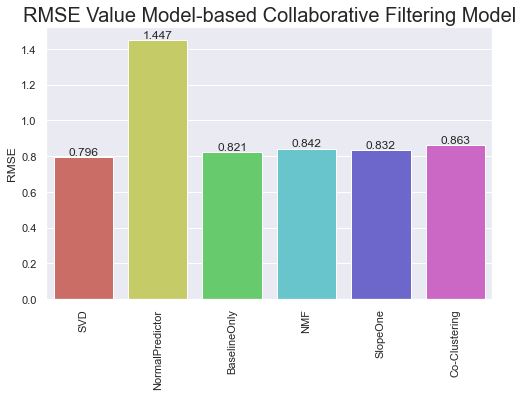

In [96]:
# Compare RMSE values between models
fig,axis = plt.subplots(figsize=(8, 5))
rmse_x = ['SVD','NormalPredictor','BaselineOnly','NMF','SlopeOne','Co-Clustering']
rmse_y = [svd_rmse,np_rmse,blo_rmse,nmf_rmse,so_rmse,cc_rmse]
ax = sns.barplot(x=rmse_x, y=rmse_y,palette='hls')
plt.title('RMSE Value Model-based Collaborative Filtering Model',fontsize=20)
plt.xticks(rotation=90)
plt.ylabel('RMSE')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_y() + p.get_height(), round(p.get_height(),3), fontsize=12, ha="center", va='bottom')
    
plt.show()

### __Cross-Validation__

For the purpose of model improvement, the process of cross-validation will be performed. In this process, reporting accuracy measures and computation times is to be expected.

##### i) SVD:

In [97]:
# Create Instance of SVD:
svd = SVD() 

# Run 5-fold cross-validation and print results
svd_cv = cross_validate(svd, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7929  0.7948  0.7937  0.7929  0.7917  0.7932  0.0010  
Fit time          44.20   43.82   44.63   44.10   45.00   44.35   0.42    
Test time         2.04    1.18    1.14    1.25    1.13    1.35    0.35    


##### ii) BaselineOnly:

In [98]:
bsl_options = {'method':'sgd', 'n_epochs':40}
blo = BaselineOnly(bsl_options=bsl_options)

# Run 5-fold cross-validation and print results
blo_cv = cross_validate(blo, data, measures=['RMSE'], cv=5, verbose=True)

#==========
# 'SGD' method performs better than 'ALS'
# Epoch 40 has the lowest mean RMSE (based on 30, 40, 50)

Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Evaluating RMSE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8219  0.8191  0.8228  0.8200  0.8215  0.8211  0.0013  
Fit time          10.72   11.42   11.40   11.36   11.52   11.29   0.29    
Test time         0.67    0.70    1.58    0.71    1.50    1.03    0.42    


### Hyperparameter Tuning with GridSearchCV:

Hyper-parameter tuning serves the purpose of choosing a set of optimal hyperparameters for a machine learning algorithm. A hyperparameter is a model's argument whose value is set before the training process begins.

This process will be performed on the SVD algorithm because it is comparatively the best-performing algorithm.

In [100]:
# Grid Search parameters:
param_grid = {'n_epochs':[30,40], 
              'n_factors':[300,400], 
              'init_std_dev':[0.005, 0.05, 0.1], 
              'random_state':[42]} 

# Setting up the GridSearch function:
grid_SVD = GridSearchCV(SVD, cv=5, measures=['rmse'], 
                        param_grid=param_grid, n_jobs=-1, joblib_verbose=10) # Passing the SVD model as a an argument and RMSE as the evaluation metric.

# Train the tuned SVD model on the data:
grid_SVD.fit(data)

# display the best score
print('Best Score is: ') 
print(grid_SVD.best_score['rmse'])

# display the best parameters from the GridSearch:
print('Best Parameters are: ')
print(grid_SVD.best_params['rmse'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 31.5min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 43.3min
[Parallel(n_jobs=-1)]: Done  44 out of  60 | elapsed: 46.7min remaining: 17.0min
[Parallel(n_jobs=-1)]: Done  51 out of  60 | elapsed: 61.5min remaining: 10.9min
[Parallel(n_jobs=-1)]: Done  58 out of  60 | elapsed: 67.2min remaining:  2.3min


Best Score is: 
0.7600490837011838
Best Parameters are: 
{'n_epochs': 40, 'n_factors': 400, 'init_std_dev': 0.005, 'random_state': 42}


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 67.4min finished


#### __Optimised SVD model__

Once the optimal parameters have been determined, the SVD model will be trained:

In [101]:
# Create an instance of the SVD model with the best paramenters:
svd_test = SVD(n_epochs = 40, n_factors = 400, init_std_dev = 0.005, random_state=42)

# Train SVD model:
svd_test.fit(trainset)

# Make Predictions using the test set:
predictions = svd_test.test(testset)

# Calculate RMSE
svd_rmse = accuracy.rmse(predictions)

RMSE: 0.7619


#### Generating a `.csv` file containing user-rating predictions for Kaggle Competition.

The final task will be creating a file with the required predictions:

In [106]:
# Create Kaggle submission file
predictions = []
for i, row in test.iterrows():
    x = (svd_test.predict(row.userId, row.movieId))
    pred = x[3]
    predictions.append(pred)
test['Id'] = test['userId'].map(str) +'_'+ test['movieId'].map(str)
results = pd.DataFrame({"Id":test['Id'],"rating": predictions})
results.to_csv("submission.csv", index=False)

In [107]:
#Save the model as pickle file
pickle.dump(svd_test, open('SVD_Opt.pkl','wb'))

# Conclusion

Throughout this project, we set out to build a movie recommendation engine. We dealt with a large dataset. This afforded us the opportunity to gather insights that could be used to better understand User behavior and allowed us to dig deeper in understanding how different features can be used to maximize consumer experience, with the aid of algorithms such as Content-Based and Collaborative-Filtering we were able to segregate groups with similar traits.

To arrive at this conclusion we took the following steps:  
1. Loading the data which comprised of 8 DataFrames
2. Cleaning the data and replacing the missing values for categorical data with empty string and missing numeric values with a 0
3. Extracting the features that were the most important for building our model which were ***titles*** and ***indices***
4. We decided on 6 models to train, namely: SVD, NormalPredictor, BaselineOnly, NMF, SlopeOne, Co-Clustering
5. The best performing model was SVD with an RMSE of 0.7619

+ ***Content-based Filtering:***
We were able to use a mathematical approach that capitalizes on the similarity features of a user based on their historical preference to make recommendation of movies that they are most likely to be interested in watching and this can be used to drive traffic as well as monitor traffic of the app.

+ ***Collaborative Filtering***
After carefully training and cross-validating a number of algorithms using features that our users interaction with the features such as ratings we observed that SVD which uses the probability that a user is mostly to take interest a certain product/services if they have interacted with that product/service such as rating a similar product previously, we noticed that SVD did a better job at assigning probabilities of recommend an accurate movie to a certain user using the users rating information.

Recommendation Engines such as the one we have created, have been shown to contribute to the growth of streaming services such as Netflix, Showmax and Hulu; as well as the ecommerce giant, Amazon.
There are several advantages that recommendation engines provide to the business environment, they include:
+ **Drive Traffic** : A recommendation engine can bring traffic to a business website through customized e-mail messages and targeted blasts.
+ **Provide Relevant Material** : By analyzing a customer’s present usage of the website, and previous browsing history, the recommendation engine can deliver appropriate item/product suggestions. The data is gathered in real-time so the software can respond as his shopping habits change.
+ **Engaging Customers** : Consumers end up being more engaged in the website when individualized item/product recommendations are made. They are able to dive even more deeply into the item/product line without needing to carry out search after search.
+ **Transform Shoppers to Clients** : Converting buyers into consumers takes an unique touch. Individualized communications from a recommendation engines suggest to a customer that they are valued as an individual.
+ **Lower Work and Overhead** : The volume of data required to create an individual shopping experience for each customer is typically far too huge to be handled manually. Utilizing an engine automates this process, reducing the workload of your IT staff and your spending plan.

# References

* https://www.kaggle.com/amar09/eda-recommendation-model-on-movielens-100k
* https://surprise.readthedocs.io/en/stable/getting_started.html 
* https://distill.pub/2016/misread-tsne/
* https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.12-Gaussian-Mixtures.ipynb
* https://learn.datacamp.com/courses/building-recommendation-engines-in-python

In [ ]:
experiment.end()
#experiment.display()